# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.mixture import GaussianMixture

from sklearn import metrics

# Prepare the Data

## Load the Data

In [ ]:
df = pd.read_excel('https://query.data.world/s/kdys6uqv5oazrf3av62phbqyimd2qh')
df.head()

,NDB_No,Shrt_Desc,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Choline_Tot_ (mg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg),GmWt_1,GmWt_Desc1,GmWt_2,GmWt_Desc2,Refuse_Pct
0,1001,"BUTTER,WITH SALT",15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0,5.00,"1 pat, (1"" sq, 1/3"" high)",14.2,1 tbsp,0.0
1,1002,"BUTTER,WHIPPED,W/ SALT",16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,1.0,24.0,41.0,583.0,0.05,0.010,0.001,0.0,0.0,0.007,0.064,0.022,0.097,0.008,4.0,0.0,4.0,4.0,18.8,0.07,2468.0,683.0,671.0,1.0,135.0,6.0,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0,3.80,"1 pat, (1"" sq, 1/3"" high)",9.4,1 tbsp,0.0
2,1003,"BUTTER OIL,ANHYDROUS",0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0,12.80,1 tbsp,205.0,1 cup,0.0
3,1004,"CHEESE,BLUE",42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0,28.35,1 oz,17.0,1 cubic inch,0.0
4,1005,"CHEESE,BRICK",41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0,132.00,"1 cup, diced",113.0,"1 cup, shredded",0.0


In [ ]:
# Hanya menggunakan data nutrisi
df = df.drop(['Shrt_Desc', 'GmWt_1', 'GmWt_Desc1',	'GmWt_2',	'GmWt_Desc2',	'Refuse_Pct'], axis=1)
df.head()

,NDB_No,Water_(g),Energ_Kcal,Protein_(g),Lipid_Tot_(g),Ash_(g),Carbohydrt_(g),Fiber_TD_(g),Sugar_Tot_(g),Calcium_(mg),Iron_(mg),Magnesium_(mg),Phosphorus_(mg),Potassium_(mg),Sodium_(mg),Zinc_(mg),Copper_mg),Manganese_(mg),Selenium_(µg),Vit_C_(mg),Thiamin_(mg),Riboflavin_(mg),Niacin_(mg),Panto_Acid_mg),Vit_B6_(mg),Folate_Tot_(µg),Folic_Acid_(µg),Food_Folate_(µg),Folate_DFE_(µg),Choline_Tot_ (mg),Vit_B12_(µg),Vit_A_IU,Vit_A_RAE,Retinol_(µg),Alpha_Carot_(µg),Beta_Carot_(µg),Beta_Crypt_(µg),Lycopene_(µg),Lut+Zea_ (µg),Vit_E_(mg),Vit_D_µg,Vit_D_IU,Vit_K_(µg),FA_Sat_(g),FA_Mono_(g),FA_Poly_(g),Cholestrl_(mg)
0,1001,15.87,717,0.85,81.11,2.11,0.06,0.0,0.06,24.0,0.02,2.0,24.0,24.0,643.0,0.09,0.000,0.000,1.0,0.0,0.005,0.034,0.042,0.110,0.003,3.0,0.0,3.0,3.0,18.8,0.17,2499.0,684.0,671.0,0.0,158.0,0.0,0.0,0.0,2.32,0.0,0.0,7.0,51.368,21.021,3.043,215.0
1,1002,16.72,718,0.49,78.30,1.62,2.87,0.0,0.06,23.0,0.05,1.0,24.0,41.0,583.0,0.05,0.010,0.001,0.0,0.0,0.007,0.064,0.022,0.097,0.008,4.0,0.0,4.0,4.0,18.8,0.07,2468.0,683.0,671.0,1.0,135.0,6.0,0.0,13.0,1.37,0.0,0.0,4.6,45.390,19.874,3.331,225.0
2,1003,0.24,876,0.28,99.48,0.00,0.00,0.0,0.00,4.0,0.00,0.0,3.0,5.0,2.0,0.01,0.001,0.000,0.0,0.0,0.001,0.005,0.003,0.010,0.001,0.0,0.0,0.0,0.0,22.3,0.01,3069.0,840.0,824.0,0.0,193.0,0.0,0.0,0.0,2.80,0.0,0.0,8.6,61.924,28.732,3.694,256.0
3,1004,42.41,353,21.40,28.74,5.11,2.34,0.0,0.50,528.0,0.31,23.0,387.0,256.0,1146.0,2.66,0.040,0.009,14.5,0.0,0.029,0.382,1.016,1.729,0.166,36.0,0.0,36.0,36.0,15.4,1.22,721.0,198.0,192.0,0.0,74.0,0.0,0.0,0.0,0.25,0.5,21.0,2.4,18.669,7.778,0.800,75.0
4,1005,41.11,371,23.24,29.68,3.18,2.79,0.0,0.51,674.0,0.43,24.0,451.0,136.0,560.0,2.60,0.024,0.012,14.5,0.0,0.014,0.351,0.118,0.288,0.065,20.0,0.0,20.0,20.0,15.4,1.26,1080.0,292.0,286.0,0.0,76.0,0.0,0.0,0.0,0.26,0.5,22.0,2.5,18.764,8.598,0.784,94.0


In [ ]:
df.shape

(8790, 47)

## Preprocessing

In [ ]:
df.isnull().sum()

NDB_No                  0
Water_(g)               1
Energ_Kcal              0
Protein_(g)             0
Lipid_Tot_(g)           0
Ash_(g)               325
Carbohydrt_(g)          0
Fiber_TD_(g)          594
Sugar_Tot_(g)        1832
Calcium_(mg)          348
Iron_(mg)             144
Magnesium_(mg)        739
Phosphorus_(mg)       579
Potassium_(mg)        426
Sodium_(mg)            83
Zinc_(mg)             706
Copper_mg)           1257
Manganese_(mg)       2160
Selenium_(µg)        1700
Vit_C_(mg)            818
Thiamin_(mg)          634
Riboflavin_(mg)       616
Niacin_(mg)           637
Panto_Acid_mg)       2242
Vit_B6_(mg)           905
Folate_Tot_(µg)      1261
Folic_Acid_(µg)      2039
Food_Folate_(µg)     1768
Folate_DFE_(µg)      2057
Choline_Tot_ (mg)    4016
Vit_B12_(µg)         1193
Vit_A_IU              711
Vit_A_RAE            1535
Retinol_(µg)         1806
Alpha_Carot_(µg)     3258
Beta_Carot_(µg)      3162
Beta_Crypt_(µg)      3270
Lycopene_(µg)        3292
Lut+Zea_ (µg

**Null values handling:**

In [ ]:
df.fillna(0, inplace=True)

## Data Splitting

In [ ]:
df_train, df_test = train_test_split(df.values, test_size=0.2, random_state=42)

In [ ]:
print('Train size:', df_train.shape[0])
print('Test size:', df_test.shape[0])

Train size: 7032
Test size: 1758


In [ ]:
products_train = []
features_train = []
for i in range(len(df_train)):
  products_train.append(df_train[i][0])
  features_train.append(df_train[i][1:])
  
products_train = np.asarray(products_train)
features_train = np.asarray(features_train).astype(np.float32)

In [ ]:
products_train.shape

(7032,)

In [ ]:
features_train.shape

(7032, 46)

In [ ]:
products_test = []
features_test = []
for i in range(len(df_test)):
  products_test.append(df_test[i][0])
  features_test.append(df_test[i][1:])
  
products_test = np.asarray(products_test)
features_test = np.asarray(features_test).astype(np.float32)

In [ ]:
products_test.shape

(1758,)

In [ ]:
features_test.shape

(1758, 46)

## Transformation

In [ ]:
features_train = preprocessing.normalize(features_train)
features_test = preprocessing.normalize(features_test)

# Build VAE

<img src="https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png">

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Input, Flatten, Dense, Lambda
from tensorflow.keras.models import Model

In [ ]:
ACTIVATION_FUNC = 'relu'
EPOCHS = 50

## Encoder

In [ ]:
ENCODING_DIM_I = 32
ENCODING_DIM_II = 16
# ENCODING_DIM_III = 8

In [ ]:
input_data = Input(shape=(46,))

# n hidden layer
encoder_layer = Dense(ENCODING_DIM_I, activation=ACTIVATION_FUNC)(input_data)
encoder_layer = Dense(ENCODING_DIM_II, activation=ACTIVATION_FUNC)(encoder_layer)
# encoder_layer = Dense(ENCODING_DIM_III, activation=ACTIVATION_FUNC)(encoder_layer)

In [ ]:
def sample_latent_features(distribution):
  distribution_mean, distribution_variance = distribution
  batch_size = tf.shape(distribution_variance)[0]
  epsilon = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
  
  # z (latent variables) = z_mean + sigma * epsilon
  # where sigma = exp(log variance/2)
  # espsilon: for reparameterization
  return distribution_mean + tf.exp(0.5 * distribution_variance) * epsilon

In [ ]:
distribution_mean = Dense(2, name='mean')(encoder_layer)
distribution_variance = Dense(2, name='log_variance')(encoder_layer)

latent_encoding = Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [ ]:
encoder = Model(input_data, latent_encoding, name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 46)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           1504        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 16)           528         dense[0][0]                      
__________________________________________________________________________________________________
mean (Dense)                    (None, 2)            34          dense_1[0][0]                    
____________________________________________________________________________________________

## Decoder

In [ ]:
decoder_input = Input(shape=(2))
decoder_layer = Dense(46, activation=ACTIVATION_FUNC)(decoder_input)

In [ ]:
decoder = Model(decoder_input, decoder_layer, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                138       
Total params: 138
Trainable params: 138
Non-trainable params: 0
_________________________________________________________________


## Variational Autoencoders

In [ ]:
encoded = encoder(input_data)
decoded = decoder(encoded)

autoencoder = Model(input_data, decoded)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
encoder (Functional)         (None, 2)                 2100      
_________________________________________________________________
decoder (Functional)         (None, 46)                138       
Total params: 2,238
Trainable params: 2,238
Non-trainable params: 0
_________________________________________________________________


## Loss Function

Comprises of two losses: Reconstruction Loss & KL (Kullback-Liebler) Divergence Loss.

In [ ]:
def get_loss(distribution_mean, distribution_variance):
  def get_reconstruction_loss(y_true, y_pred):
    reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
    reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
    return reconstruction_loss_batch*46
    
  def get_kl_loss(distribution_mean, distribution_variance):
    kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
    kl_loss_batch = tf.reduce_mean(kl_loss)
    return kl_loss_batch*(-0.5)
    
  def total_loss(y_true, y_pred):
    reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
    kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
    return reconstruction_loss_batch + kl_loss_batch
    
  return total_loss

## Training

In [ ]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
train = autoencoder.fit(features_train, features_train, epochs=EPOCHS, validation_data=(features_test, features_test))

Train on 7032 samples, validate on 1758 samples
Epoch 1/50
6240/7032 [=========================>....] - ETA: 0s - loss: 1.1718WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
7032/7032 [==============================] - 0s 51us/sample - loss: 1.1259 - val_loss: 0.7531
Epoch 2/50
7032/7032 [==============================] - 0s 45us/sample - loss: 0.6052 - val_loss: 0.5414
Epoch 3/50
7032/7032 [==============================] - 0s 44us/sample - loss: 0.5212 - val_loss: 0.5244
Epoch 4/50
7032/7032 [==============================] - 0s 45us/sample - loss: 0.5152 - val_loss: 0.5207
Epoch 5/50
7032/7032 [==============================] - 0s 46us/sample - loss: 0.5129 - val_loss: 0.5184
Epoch 

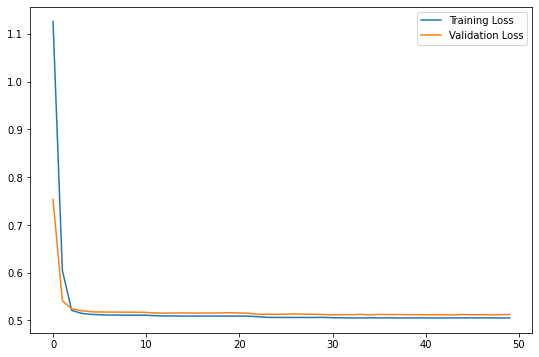

In [ ]:
loss = train.history['loss']
val_loss = train.history['val_loss']

plt.figure(figsize=(9, 6))
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

In [ ]:
features_test[:5]

array([[1.17716879e-01, 4.04989243e-01, 5.32078743e-02, 2.13487186e-02,
        2.14065751e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.69992836e-02, 5.86270122e-03, 4.43559662e-02, 4.18488890e-01,
        7.30909169e-01, 1.63924217e-01, 1.82823706e-02, 2.37207991e-04,
        2.89278032e-05, 5.92055731e-02, 0.00000000e+00, 1.71638298e-04,
        5.88198658e-04, 8.23092461e-03, 1.93816284e-03, 7.65622535e-04,
        1.34996418e-02, 0.00000000e+00, 1.34996418e-02, 1.34996418e-02,
        1.98251888e-01, 9.71974153e-03, 4.24274430e-02, 1.34996418e-02,
        1.34996418e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.50707613e-04, 1.92852021e-04,
        9.64260101e-03, 3.08563234e-03, 8.73233937e-03, 1.02172997e-02,
        1.11854170e-03, 1.83209419e-01],
       [3.67332925e-03, 6.52323430e-03, 3.26161709e-04, 8.55506150e-05,
        1.55060494e-04, 1.10681111e-03, 0.00000000e+00, 0.00000000e+00,
        6.95098750e-03,

In [ ]:
encoded_datapoints = encoder.predict(features_test)
decoded_datapoints = decoder.predict(encoded_datapoints)

In [ ]:
decoded_datapoints[:5]

array([[0.12842833, 0.35366622, 0.        , 0.01666548, 0.        ,
        0.03762238, 0.        , 0.        , 0.09033366, 0.        ,
        0.04650219, 0.22420353, 0.39824724, 0.30251193, 0.        ,
        0.        , 0.        , 0.        , 0.00816839, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.04070425,
        0.        , 0.01881324, 0.03518686, 0.04190169, 0.        ,
        0.21358535, 0.03721539, 0.        , 0.        , 0.02527364,
        0.        , 0.02447729, 0.0356528 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.06365819],
       [0.12885171, 0.35161927, 0.        , 0.01617029, 0.        ,
        0.0373389 , 0.        , 0.        , 0.09023049, 0.        ,
        0.04608484, 0.22364327, 0.39609602, 0.3032323 , 0.        ,
        0.        , 0.        , 0.        , 0.00934327, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.04130499,
        0.        , 0.01985

## Representation Learning Based on VAE

In [ ]:
all_products = np.concatenate((products_train, products_test))
all_products.shape

(8790,)

In [ ]:
all_features = np.concatenate((features_train, features_test))
all_features.shape

(8790, 46)

In [ ]:
encoded_datapoints = encoder.predict(all_features)

In [ ]:
encoded_datapoints[:5]

array([[-0.12483104,  0.14240539],
       [ 0.46194276, -0.25718313],
       [-0.0017008 , -1.5738379 ],
       [-0.30666792,  0.9731167 ],
       [ 1.5152398 , -1.6770841 ]], dtype=float32)

In [ ]:
encoded_datapoints.shape

(8790, 2)

# Clustering I: K-Means

In [ ]:
silhouette = []

for i in range(2,11):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(encoded_datapoints)
  labels = kmeans.labels_
  silhouette.append(metrics.silhouette_score(encoded_datapoints, labels, metric='euclidean'))

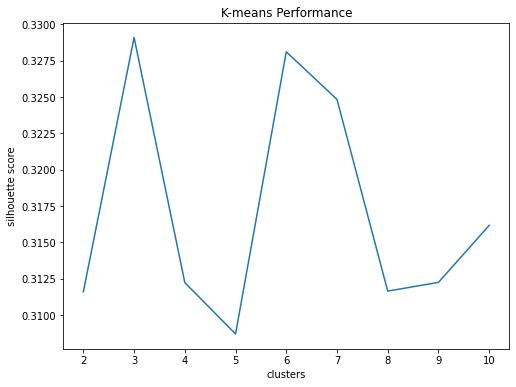

In [ ]:
i = list(range(2,11))
plt.figure(figsize=(8,6))
plt.plot(i, silhouette)
plt.xlabel("clusters")
plt.ylabel("silhouette score")
plt.title("K-means Performance")
plt.show()

In [ ]:
# Get the indices of maximum element in numpy array
max_index = np.where(silhouette == np.amax(silhouette))
max_index =  max_index[0] + 2

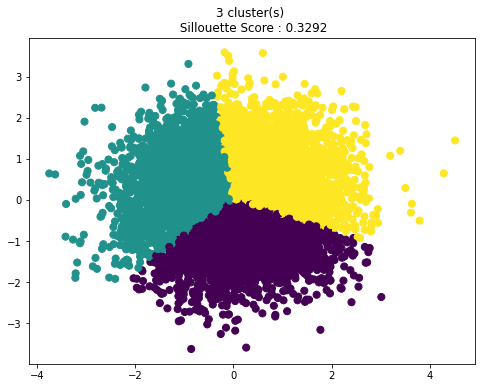

In [ ]:
kmeans = KMeans(n_clusters=max_index[0])
kmeans.fit(encoded_datapoints)
labels = kmeans.labels_
silhouette = metrics.silhouette_score(encoded_datapoints, labels, metric='euclidean')
plt.figure(figsize=(8, 6))
plt.scatter(encoded_datapoints[:, 0], encoded_datapoints[:, 1], c=labels, s=50, cmap='viridis')
# centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title("{} cluster(s) \n Sillouette Score : {:.4f}" .format(max_index[0],silhouette))
plt.show()

# Clustering II: Agglomerative Hierarchical Clustering

In [ ]:
# plt.figure(figsize=(15,8))
# plt.ylabel('Distance')
# plt.xlabel('Samples')
# dendrogram = sch.dendrogram(sch.linkage(encoded_datapoints, method='ward'))

In [ ]:
silhouette = []

for i in range(2,11):
  agglomerative_hierarchical_clustering_model = AgglomerativeClustering(n_clusters=i)
  clusters = agglomerative_hierarchical_clustering_model.fit_predict(encoded_datapoints)
  silhouette.append(metrics.silhouette_score(encoded_datapoints, clusters, metric='euclidean'))

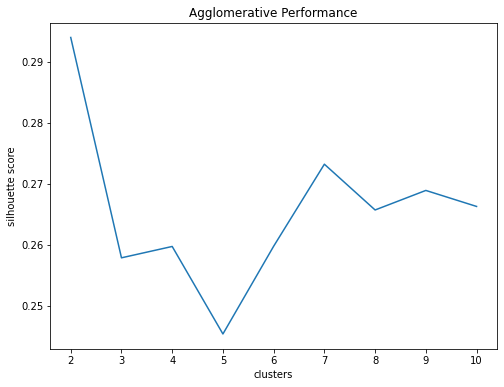

In [ ]:
i = list(range(2,11))
plt.figure(figsize=(8,6))
plt.plot(i, silhouette)
plt.xlabel("clusters")
plt.ylabel("silhouette score")
plt.title("Agglomerative Performance")
plt.show()

In [ ]:
# Get the indices of maximum element in numpy array
max_index = np.where(silhouette == np.amax(silhouette))
max_index =  max_index[0] + 2

In [ ]:
agglomerative_hierarchical_clustering_model = AgglomerativeClustering(n_clusters=max_index[0])
clusters = agglomerative_hierarchical_clustering_model.fit_predict(encoded_datapoints)

In [ ]:
silhouette = metrics.silhouette_score(encoded_datapoints, clusters, metric='euclidean')

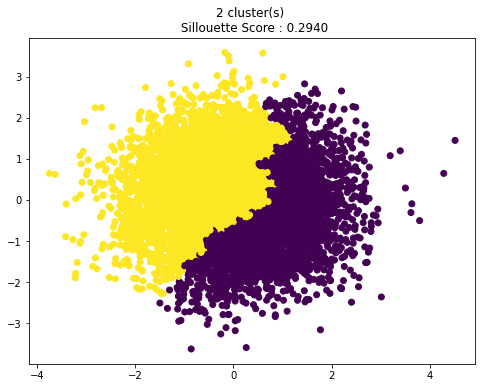

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(encoded_datapoints[:, 0], encoded_datapoints[:, 1], c=clusters, cmap='viridis')
plt.title("{} cluster(s) \n Sillouette Score : {:.4f}" .format(max_index[0],silhouette))
plt.show()

# Clustering III: Gaussian Mixture Model

In [ ]:
silhouette = []

for i in range(2,11):
  model = GaussianMixture(n_components=i)
  model.fit(encoded_datapoints)
  yhat = model.predict(encoded_datapoints)
  silhouette.append(metrics.silhouette_score(encoded_datapoints, yhat, metric='euclidean'))

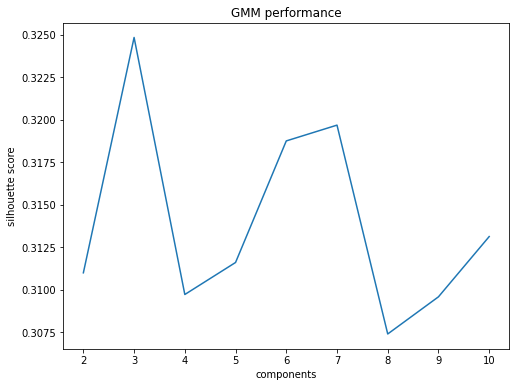

In [ ]:
i = list(range(2,11))
plt.figure(figsize=(8,6))
plt.plot(i, silhouette)
plt.xlabel("components")
plt.ylabel("silhouette score")
plt.title("GMM performance")
plt.show()

In [ ]:
# Get the indices of maximum element in numpy array
max_index = np.where(silhouette == np.amax(silhouette))
max_index =  max_index[0] + 2

In [ ]:
model = GaussianMixture(n_components=max_index[0]) # Sesuaikan dengan silhouette tertinggi
model.fit(encoded_datapoints)
clusters = model.predict(encoded_datapoints)

In [ ]:
silhouette = metrics.silhouette_score(encoded_datapoints, clusters, metric='euclidean')
print(silhouette)

0.3262507


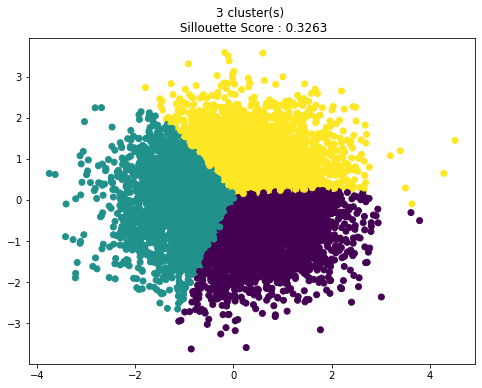

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(encoded_datapoints[:, 0], encoded_datapoints[:, 1], c=clusters, cmap='viridis')
plt.title("{} cluster(s) \n Sillouette Score : {:.4f}" .format(max_index[0],silhouette))
plt.show()